# Measuring Lifetime by Instrument Automation
> Prof. Siddharth Dhomkar and Mr. Atanu Ghosh

#### Installing Modules

In [3]:
# !pip install pulsestreamer
# !pip install nidaqmx
import numpy as np
import inspect,dis
import sys
import time
from tqdm import trange
from plotly.subplots import make_subplots
from plotly import graph_objs as go
import scipy
from scipy.optimize import curve_fit
import pulsestreamer
import nidaqmx
import nidaqmx.stream_readers
import pprint
from pulsestreamer import PulseStreamer,findPulseStreamers,OutputState,TriggerStart,Sequence,TriggerRearm
import os
import scipy.stats as stats
import tkinter as tk
from tkinter import *
from tkinter.messagebox import askyesno
permission=0 # creating a gloabl variable

program_path = os.getcwd()

#### loading Instruments

In [5]:
# loading the local Pulse Streamer system
IPaddress = findPulseStreamers(search_serial='')[0][0]
pulser = PulseStreamer(IPaddress)

# loading the local NIDAQmx system
system = nidaqmx.system.System.local()
DAQ_device = system.devices['Dev1']

Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0


#### Functions

##### Sequence Functions

In [210]:
# For Lifetime Measurements

# Laser_Initialization Sequence
def seqInit(*args):
    laser_block = [(delay2,0),(laser_on,1),(delay2,0)]
    seq_init = pulser.createSequence()
    seq_init.setDigital(laser_port,laser_block)
    # condition_check(seq_init)
    return seq_init

# Laser_Read Sequence
def seqRead(*args):
    laser_block = [(delay2, 0), (laser_on, 1), (delay2, 0)]
    trigger_block = [(delay2 + delay3, 0),(read_on, 1),(laser_on - read_on - delay3, 0),(delay2, 0)]
    timing_block = [(delay2 + delay3, 0),(read_on - triggerTimingDelay, 1),(laser_on - read_on - delay3 + triggerTimingDelay, 0),(delay2, 0),]
    seq_read = pulser.createSequence()
    seq_read.setDigital(laser_port, laser_block)
    seq_read.setDigital(trigger_port, trigger_block)
    seq_read.setDigital(timing_port, timing_block)
    condition_check(seq_read)
    return seq_read

# Free Evolution Sequence
def seqLifetime(*args):
    timing_read_on = read_on-triggerTimingDelay
    for t in range(steps-1): # neglecting the last step
        trigger_block = [(read_on,1),(delay1+timeRange[t],0),(read_on,1),(timeRange[-1]-timeRange[t]-delay1-2*read_on,0)]
        timing_block = [(timing_read_on,1),(delay1+timeRange[t]+triggerTimingDelay,0),
                     (timing_read_on,1),((timeRange[-1]-timeRange[t]-delay1-triggerTimingDelay-2*timing_read_on),0)]

        seq_evolution = pulser.createSequence()
        # seq_evolution.setDigital(laser_port, laser_block)
        seq_evolution.setDigital(trigger_port, trigger_block)
        seq_evolution.setDigital(timing_port, timing_block)
        # condition_check(seq_evolution)
        seq_lifetime = seqInit(*args) + seq_evolution
        yield seq_lifetime

In [212]:
# seq_number = 1
# pulser.reset()
# sequence = seqLifetime(*pulse_args) 
# print(pulser.hasSequence())
# for seq in sequence:
#     print(f'Seq. No. : {seq_number}'); seq_number+=1
#     seq.plot()

In [214]:
# # Delay Measurement Sequence
# def seqDelay(*args):
    
#     triggerTimingDelay=2
#     laser_on=1*1e3; laser_off=laser_on; delay_read_on=30; Tmax=3*laser_on; steps=20
    
#     delay_timeRange=np.linspace(0,Tmax,num=steps)
#     timing_read_on = delay_read_on-triggerTimingDelay
    
#     allowed_steps = (delay_timeRange[-1]-(4*delay_read_on))/delay_read_on
#     if delay_timeRange.shape[0] > allowed_steps:
#         raise Exception(f'Please reduce the steps or read_on time. \nMaximum allowed steps: {allowed_steps}')
#     for t in range(steps-1): # neglecting the last step
#         laser_block = [(laser_off,0),(laser_on,1),(laser_off,0)]
#         trigger_block = [(delay_read_on,0),(delay_read_on,1),(delay_read_on+delay_timeRange[t],0),(delay_read_on,1),(delay_timeRange[-1]-4*delay_read_on-delay_timeRange[t],0)]
#         timing_block = [(delay_read_on,0),(timing_read_on,1),(delay_read_on+delay_timeRange[t]+triggerTimingDelay,0),
#                      (timing_read_on,1),((delay_timeRange[-1]-2*timing_read_on-2*delay_read_on-2*triggerTimingDelay-delay_timeRange[t]),0)]

#         seq_delay = pulser.createSequence()
#         seq_delay.setDigital(laser_port, laser_block)
#         seq_delay.setDigital(trigger_port, trigger_block)
#         seq_delay.setDigital(timing_port, timing_block)
#         condition_check(seq_delay)
#         yield seq_delay   

# seq_number = 1
# sequence = seqDelay(*pulse_args) 
# print(pulser.hasSequence())
# # for seq in sequence:
#     # print(f'Seq. No. : {seq_number}'); seq_number+=1
#     # seq.plot()

# sequence = seqDelay(*pulse_args)   
# # if pulser.hasSequence()!=0:
# #     raise Exception('Pulse Streamer has no Sequence uploaded!')

# for s in sequence:
#     reSet = pulser.reset()
#     pulser.stream(s,n_runs=10,final=([],0,0))
#     print(pulser.isStreaming(),pulser.hasFinished())
#     print(f'Seq. No. : {seq_number}'); seq_number+=1
#     # s.plot()

In [216]:
# # For T1 Measurements

# delay_timeRange=0; snr_timeRange=0; T1_timeRange=0
# delay_read_on=0; snr_read_on=0; T1_read_on=0

# # Delay Measurement Sequence
# def seqDelay(*args):
    
#     triggerTimingDelay=2
#     laser_on=3*1000; laser_off=laser_on; delay_read_on=30; Tmax=3*laser_on; steps=20
    
#     delay_timeRange=np.linspace(0,Tmax,num=steps)
#     timing_read_on = delay_read_on-triggerTimingDelay
    
#     allowed_steps = (delay_timeRange[-1]-(4*delay_read_on))/delay_read_on
#     if delay_timeRange.shape[0] > allowed_steps:
#         raise Exception(f'Please reduce the steps or read_on time. \nMaximum allowed steps: {allowed_steps}')
#     for t in range(steps-1): # neglecting the last step
#         laser_block = [(laser_off,0),(laser_on,1),(laser_off,0)]
#         trigger_block = [(delay_read_on,0),(delay_read_on,1),(delay_read_on+delay_timeRange[t],0),(delay_read_on,1),(delay_timeRange[-1]-4*delay_read_on-delay_timeRange[t],0)]
#         timing_block = [(delay_read_on,0),(timing_read_on,1),(delay_read_on+delay_timeRange[t]+triggerTimingDelay,0),
#                      (timing_read_on,1),((delay_timeRange[-1]-2*timing_read_on-2*delay_read_on-2*triggerTimingDelay-delay_timeRange[t]),0)]

#         seq_delay = pulser.createSequence()
#         seq_delay.setDigital(laser_port, laser_block)
#         seq_delay.setDigital(trigger_port, trigger_block)
#         seq_delay.setDigital(timing_port, timing_block)
#         condition_check(seq_delay)
#         yield seq_delay
        
# # SNR Measurement Sequence
# def seqSNR(*args):
        
#     triggerTimingDelay=2
#     laser_on=3*1000; laser_off=laser_on; snr_read_on=8; Tmax=laser_on; equilibrium_evolution=15*1e6; steps=290
    
#     snr_timeRange=np.linspace(0,Tmax,num=steps)
#     timing_read_on = snr_read_on-triggerTimingDelay
        
#     allowed_steps = (snr_timeRange[-1]-snr_read_on)/snr_read_on
#     if snr_timeRange.shape[0] > allowed_steps:
#         raise Exception(f'Please reduce the steps or read_on time. \nMaximum allowed steps: {allowed_steps}')
#     for t in range(steps-1): # neglecting the last step
#         laser_block = [(laser_off,0),(laser_on,1),(laser_off,0),(laser_on,1),(equilibrium_evolution,0),(laser_on,1),(laser_off,0)]
#         trigger_block = [(laser_off,0),(laser_off,0),(laser_off,0),(snr_timeRange[t]+snr_read_on,1),
#                          (equilibrium_evolution+laser_on-snr_timeRange[t]-snr_read_on,0),(snr_timeRange[t]+snr_read_on,1),(laser_on+laser_off-snr_timeRange[t]-snr_read_on,0)]
#         timing_block = [(laser_off,0),(laser_off,0),(laser_off,0),(snr_timeRange[t]+timing_read_on,1),
#                          (equilibrium_evolution+laser_on-snr_timeRange[t]-timing_read_on,0),(snr_timeRange[t]+timing_read_on,1),(laser_on+laser_off-snr_timeRange[t]-timing_read_on,0)]

#         seq_snr = pulser.createSequence()
#         seq_snr.setDigital(laser_port, laser_block)
#         seq_snr.setDigital(trigger_port, trigger_block)
#         seq_snr.setDigital(timing_port, timing_block)
#         condition_check(seq_snr)
#         yield seq_snr     
        
# # T1 Measurement Sequence
# def seqT1(*args):
        
#     triggerTimingDelay=2
#     laser_on=5*1000; laser_off=laser_on; T1_read_on=1*1000; Tmax=15*1e6; introduced_delay=8; steps=290   
    
#     T1_timeRange=np.linspace(0,Tmax,num=steps)
#     timing_read_on = T1_read_on-triggerTimingDelay
        
#     for t in range(steps-1): # neglecting the last step
#         laser_block = [(laser_off,0),(laser_on,1),(laser_off,0),(laser_on,1),(T1_timeRange[t]+introduced_delay,0),(laser_on,1),(laser_off,0)]
#         trigger_block = [(laser_off,0),(laser_off,0),(laser_off,0),(T1_read_on,1),
#                          (laser_on-T1_read_on,0),(T1_timeRange[t]+introduced_delay,0),(T1_read_on,1),(laser_on+laser_off-T1_read_on,0)]
#         timing_block = [(laser_off,0),(laser_off,0),(laser_off,0),(timing_read_on,1),
#                          (laser_on-timing_read_on,0),(T1_timeRange[t]+introduced_delay,0),(timing_read_on,1),(laser_on+laser_off-timing_read_on,0)]

#         seq_T1 = pulser.createSequence()
#         seq_T1.setDigital(laser_port, laser_block)
#         seq_T1.setDigital(trigger_port, trigger_block)
#         seq_T1.setDigital(timing_port, timing_block)
#         # condition_check(seq_T1)
#         yield seq_T1       

# # Function to check the conditions
# def condition_check(sequence):
#     if sequence.isEmpty()!=0:
#         raise Exception(f"{list(locals().keys())} is empty!")
#     if sequence.getDuration()%8!=0:
#         raise Exception(f"{list(locals().keys())} duration is not multiple of 8ns!")

##### Streaming and Collecting Data

In [270]:
# Function for doing the Lifetime measurement
def lifeitme(*args):
# def T1_measurement(*args):

    numberofpoints=samples*2
    buffersamplecount=numberofpoints
    count_per_average = buffersamplecount*(steps-1) # as we are ignoring the very last steps
    DAQ_device.reset_device()
    pulser.reset()

    # Counter
    counter = nidaqmx.Task()
    ciChannel = counter.ci_channels.add_ci_count_edges_chan('/Dev1/ctr1',edge=nidaqmx.constants.Edge.RISING, initial_count=0,
                                                             count_direction=nidaqmx.constants.CountDirection.COUNT_UP)
    # print(task.ci_channels[0].ci_count_edges_term)

    # Trigger
    counter.triggers.pause_trigger.dig_lvl_src='/Dev1/PFI4'
    counter.triggers.pause_trigger.trig_type=nidaqmx.constants.TriggerType.DIGITAL_LEVEL
    counter.triggers.pause_trigger.dig_lvl_when=nidaqmx.constants.Level.LOW

    # Timing
    counter.timing.cfg_samp_clk_timing(rate=1e8,source='/Dev1/PFI5',active_edge=nidaqmx.constants.Edge.FALLING,
                                        sample_mode = nidaqmx.constants.AcquisitionType.FINITE, samps_per_chan=count_per_average)

    # Pulse streamer Gating
    gate_task = nidaqmx.Task()
    gate_task.do_channels.add_do_chan(lines = 'Dev1/port0/line7')

    # Counter read task
    reader = nidaqmx.stream_readers.CounterReader(counter.in_stream)
    highCount = np.zeros(buffersamplecount, dtype = np.uint32)

    cps = []
    callback=[]

    # Callback function
    def readBuffer(task_handle, every_n_samples_event_type, number_of_samples, callback_data):
        counter.in_stream.read_all_avail_samp = True
        readPixels=reader.read_many_sample_uint32(highCount, number_of_samples_per_channel= -1, timeout=10.0)  #10s
        cps.extend(highCount)
        callback.extend([1])
        return 0
    time.sleep(0.01)
    counter.register_every_n_samples_acquired_into_buffer_event(buffersamplecount,readBuffer)

    
    t=0
    run=0
    data=[]
    # print("Preparing for the experiment...")
    print(f"callback number in beginning: {len(callback)}\n")

    for i in trange(averages):

        print(run)
        time.sleep(0.05)
        # counter.control(nidaqmx.constants.TaskMode.TASK_RESERVE)
        # gate_task.control(nidaqmx.constants.TaskMode.TASK_RESERVE)
        time.sleep(0.05)
        counter.start()

        # reSet = pulser.reset()
        # sequence = seqDelay(*pulse_args)   
        # print('Sequence uploading...')
        sequence = seqLifetime(*pulse_args)
        pulser.setTrigger(start=TriggerStart.HARDWARE_RISING,rearm=TriggerRearm.AUTO)
        # if pulser.hasSequence()!=0:
        #     raise Exception('Pulse Streamer has no Sequence uploaded!')
 
        # print('Sequence going to run...')
        seq_num=0
        start1=time.time_ns()
        for s in sequence:
            t1=len(callback)

            # performing the streaming samples_number times
            seq_num=seq_num+1
            # s.plot()
            pulser.stream(s,n_runs=samples,final=([],0,0))
            
            gate_task.write(True)
            # print('Inside gate_task')
            while len(callback)==t1:
                 time.sleep(0.005)
            gate_task.write(False)
            # print(f'Sequence number : {seq_num}')

        # print('Sequence running completed.')
        end1=time.time_ns()
    #  print('Time(s) for single average: ', (end1-start1)/1e9)
        print(f"callback number at {i+1}-th average end: {len(callback)}\n")
        run=run+1
        counter.control(nidaqmx.constants.TaskMode.TASK_UNRESERVE)
        # gate_task.control(nidaqmx.constants.TaskMode.TASK_UNRESERVE)
    
    # reSet = pulser.reset()
    data=signal_counts(cps,count_per_average)
    counter.close()
    gate_task.close()
    return data


# Function to Modify the Data
def signal_counts(all_counts,counts_in_one_average,*args):
    all_counts=np.array(all_counts)
    no_of_averages=int(len(all_counts)/counts_in_one_average)
    print("Crosscheck number of averges=",no_of_averages)

    # Changing the cumulative counts to actual counts
    cumulative_counts = np.reshape(all_counts,(no_of_averages,counts_in_one_average))
    modified_matrix = np.delete(cumulative_counts, -1, 1)
    zero_array = np.zeros(no_of_averages, dtype=int)
    new_matrix = np.hstack((zero_array[:, np.newaxis], modified_matrix))
    actual_counts = np.subtract(cumulative_counts,new_matrix)
    averaged_actual_counts = np.mean(actual_counts,axis=0)

    # Separating Reference and Signal and averaging over Samples
    reference_samples = np.mean(np.reshape(averaged_actual_counts[::2],(steps-1,samples)),axis=1)
    signal_samples = np.mean(np.reshape(averaged_actual_counts[1::2],(steps-1,samples)),axis=1)

    signal_photon = signal_samples/reference_samples
    return signal_photon
    
    # return signal_samples  # for only delay measurements

In [244]:
# reSet = pulser.reset()
# for s in seqDelay(*pulse_args):
#     pulser.stream(s,n_runs=samples,final=([],0,0))
#     # reSet = pulser.reset()

In [246]:
# for i in range(int(1e9)):    
#     if pulser.hasFinished()==1:
#         s.plot()

##### Other Functions

In [26]:
# Curve_fitting Function
def curveFit(x,y0,y_max,tau):
    return y0+y_max*np.exp(-x/tau)

# Function to calculate the Lifetime
def lifetime_fit(*args):
    indices = np.where(y_old!=0)
    yOld = y_old[indices]; xOld = x_old[indices]
    if type(fit_range)==np.ndarray:
        range_indicies = np.where(np.logical_and(xOld>=fit_range[0],xOld<=fit_range[1]))
        x_old_ranged = xOld[range_indicies]; y_old_ranged = yOld[range_indicies]
        coefficient, covariance_matrix = curve_fit(curveFit,x_old_ranged,y_old_ranged,p0=guess_params,absolute_sigma=False)
        error_bars = np.sqrt(np.diag(covariance_matrix))
        condition_number =  np.format_float_scientific(np.linalg.cond(covariance_matrix),precision=2)
        x_curve_fit = x_old_ranged; y_curve_fit = y_old_ranged
    else:
        coefficient, covariance_matrix = curve_fit(curveFit,xOld,yOld,p0=guess_params,absolute_sigma=False)
        error_bars = np.sqrt(np.diag(covariance_matrix))
        condition_number =  np.format_float_scientific(np.linalg.cond(covariance_matrix),precision=2)
        x_curve_fit = xOld; y_curve_fit = yOld

    x_new = x_curve_fit
    y_new = curveFit(x_new,*coefficient)

    # Different ways of 'Goodness of Fit' Test
    chi_square_test, p_value = stats.chisquare(y_curve_fit, y_new)
    ss_res = np.sum(np.square(y_curve_fit-y_new )); ss_total = np.sum(np.square(y_curve_fit-np.mean(y_curve_fit)))
    r_squared = 1-(ss_res/ss_total)
    mean_squared_error = np.square(np.subtract(y_new,y_curve_fit)).mean()

    print(f'Lifetime in nano_second is : {coefficient[2]}.\n')
    print(f'Chi_square, p-value, R_squared,MeanSquaredError and Condition Number are : {np.round(chi_square_test,3)}\t{np.round(p_value,3)}\
    \t{np.round(r_squared,3)}\t{np.round(mean_squared_error,5)}\t{condition_number}.\n')
    if p_value<=0.05:
        print('The p_value of fitting is low. Please check the fitting!')
    return xOld,yOld,x_new,y_new,coefficient,error_bars

# Replacing mistakes in file naming
def replace_space(name):
    name = name.replace(' ', '_').replace('.','_').replace('__','_').replace('___','_')
    if name[-1]=='_':  name=name[:-1]
    return name

# Tkinter Messagebox
def tkinter_permission(file_type):
    root = tk.Tk()
    root.title('Permission accesss')
    root.geometry('300x150')
    root.eval('tk::PlaceWindow . center')
    def confirmation():
        globals()['permission'] = askyesno(title = None,message='Confirmation of Overwriting!')
        if globals()['permission']:
            top = Toplevel(root)     # using Toplevel
            top.update_idletasks()
            screen_width = top.winfo_screenwidth()
            screen_height = top.winfo_screenheight()
            size = tuple(int(_) for _ in top.geometry().split('+')[0].split('x'))
            x = screen_width/2 - size[0]/2
            y = screen_height/2 - size[1]/2
            top.geometry("+%d+%d" % (x, y))

            top.title(None)
            Message(top, text=f'{file_type} is going to be overwritten!', padx=100, pady=100).pack()
            top.after(1500, top.destroy)       
            root.after(1500, root.destroy)
        else:
            root.destroy()
    root_button = Button(root,text=f'Do you want to overwrite\n the exiting {file_type}?',command=confirmation)
    root_button.pack(side = TOP, expand=0.5)
    root.mainloop()


# Saving file in given directory
def file_save(directory_name,file_name,contents):
    # file_name = file_name+'.txt'
    file_name = file_name+'.npz'
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)
    total_path = os.path.join(directory_name, file_name)
    if os.path.exists(total_path)==True:
        tkinter_permission(file_type='Data_file')
        if globals()['permission']==0:
            raise Exception('File is not saved!')
        # print('The same file name already exist. Do you want to overwrite it?\n')
        # overwrite_permission = input('Type 0 or 1 : ')
        # if int(overwrite_permission)==0:
        #     raise Exception('New data file has not been saved')
        # else:
        #     print('File is going to be overwritten.')
    np.savetxt(total_path,np.transpose(contents),newline='\n') # saving in column mode
    if os.path.exists(total_path)==False:
        raise Exception('Saved file does not exist!\n')
    elif os.stat(total_path).st_size == False:
        raise Exception('Saved file is empty!\n')
    else:
        print(f'Saving data_file {file_name} is successful!\n')

# Saving Image in given directory
def image_save(directory_name,file_name,fig_to_save,extension):
    file_name = file_name+'.'+extension
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)
    total_path = os.path.join(directory_name, file_name)
    if os.path.exists(total_path)==True:
        tkinter_permission(file_type='Image_file')
        if globals()['permission']==0:
            raise Exception('Image is not saved!')
    if str(extension)=='html':
        fig_to_save.write_html(total_path)                          # saving image in 'html' format
    else:
        fig_to_save.write_image(total_path)                         # saving image in mentioned static format
    if os.path.exists(total_path)==False:
        raise Exception('Saved image does not exist!\n')
    elif os.stat(total_path).st_size == False:
        raise Exception('Saved image is empty!\n')
    else:
        print(f'Saving Image {file_name} is successful!\n')

In [28]:
# permission = 0

# # Tkinter Messagebox
# def tkinter_permission(file_type):
#     root = tk.Tk()
#     root.title('Permission accesss')
#     root.geometry('300x150')
#     root.eval('tk::PlaceWindow . center')
#     def confirmation():
#         globals()['permission'] = askyesno(title = None,message='Confirmation of Overwriting!')
#         if globals()['permission']:
#             top = Toplevel(root)     # using Toplevel
#             top.update_idletasks()
#             screen_width = top.winfo_screenwidth()
#             screen_height = top.winfo_screenheight()
#             size = tuple(int(_) for _ in top.geometry().split('+')[0].split('x'))
#             x = screen_width/2 - size[0]/2
#             y = screen_height/2 - size[1]/2
#             top.geometry("+%d+%d" % (x, y))

#             top.title(None)
#             Message(top, text=f'{file_type} is going to be overwritten!', padx=100, pady=100).pack()
#             top.after(1500, top.destroy)       
#             root.after(1500, root.destroy)
#         else:
#             root.destroy()
#     root_button = Button(root,text=f'Do you want to overwrite\n the exiting {file_type}?',command=confirmation)
#     root_button.pack(side = TOP, expand=0.5)
#     root.mainloop()

# total_path = r"C:\Users\Administrator\OneDrive\Desktop\T1_measurement\Instrument_Automation\Experimental_Applications\Exp_Data\Empty_data.txt"
# def check_tkinter(*args):
#     if os.path.exists(total_path)==True:
#         tkinter_permission('file')
#         if globals()['permission']==0:
#             raise Exception('File is not saved!')
#         if globals()['permission']==1:
#             print(f"File is successfully saved")
# check_tkinter(total_path)

#### Fig Template

In [31]:
fig_template = go.layout.Template()
fig_template.layout = {
    'template': 'simple_white+presentation',
    'autosize': False,
    'width': 800,
    'height': 600,
    # 'opacity': 0.2,
    'xaxis': {
        'ticks': 'inside',
        'mirror': 'ticks',
        'linewidth': 1.5+0.5,
        'tickwidth': 1.5+0.5,
        'ticklen': 6,
        'showline': True,
        'showgrid': False,
        'zerolinecolor': 'white',
        },
    'yaxis': {
        'ticks': 'inside',
        'mirror': 'ticks',
        'linewidth': 1.5+0.5,
        'tickwidth': 1.5+0.5,
        'ticklen': 6,
        'showline': True,
        'showgrid': False,
        'zerolinecolor': 'white'
        },
    'font':{'family':'mathjax',
            'size': 22,
            }
}

#### Setting Parameters and getting Data

In [34]:
(9*1e3-120)/30

296.0

In [287]:
# For Lifetime Measurements 
delay1=8                # delay between reference and signal
delay2=8                # delay around laser_on time
delay3=8                # delay between laser_start and reference for seqRead
triggerTimingDelay=2    # delay between Trigger and Timing
laser_on=200e3; read_on=2e3; Tmax=200e3
steps=10; samples=1000; averages=5
timeRange=np.linspace(0,Tmax,num=steps)

allowed_steps = (timeRange[-1]-(2*read_on+delay1))/read_on
if timeRange.shape[0] > allowed_steps:
    raise Exception(f'Please reduce the steps or read_on time. \nMaximum allowed steps: {allowed_steps}')

In [289]:
laser_port=0; trigger_port=1; timing_port=2

pulse_args = [delay1,delay2,delay3,laser_on,timeRange,triggerTimingDelay,read_on,averages,samples,steps,laser_port,trigger_port,timing_port]

In [291]:
# Data Collection
signal_data  = lifeitme(*pulse_args)

# signal_data  = T1_measurement(*pulse_args)

callback number in beginning: 0



  0%|          | 0/5 [00:00<?, ?it/s]

0


 20%|██        | 1/5 [00:04<00:16,  4.02s/it]

callback number at 1-th average end: 9

1


 40%|████      | 2/5 [00:08<00:12,  4.00s/it]

callback number at 2-th average end: 18

2


 60%|██████    | 3/5 [00:12<00:07,  4.00s/it]

callback number at 3-th average end: 27

3


 80%|████████  | 4/5 [00:15<00:03,  3.99s/it]

callback number at 4-th average end: 36

4


100%|██████████| 5/5 [00:19<00:00,  3.99s/it]

callback number at 5-th average end: 45

Crosscheck number of averges= 5


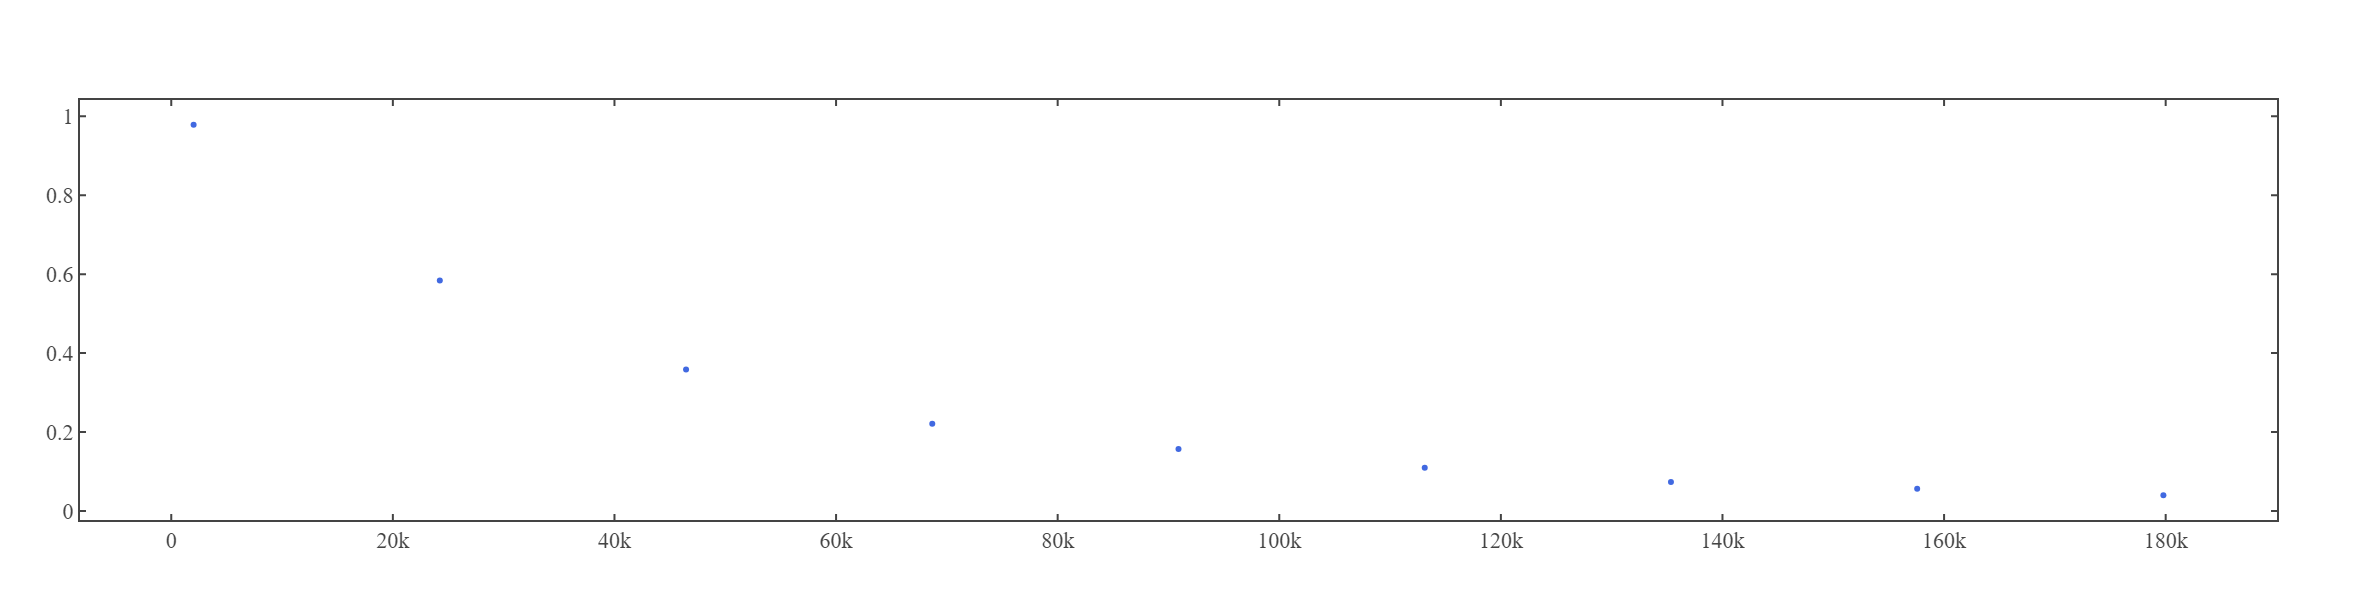

In [295]:
# For Lifetime Measurement

x_old=delay1+delay2+read_on+timeRange[:-1]
y_old=signal_data
fig = go.Figure()
fig.add_scatter(x=x_old,y=y_old,mode='markers',marker=dict(color="royalblue"),name='Experimental Data' )
fig.update_layout(template = fig_template,width=800,height=600)
fig.show()

#### Saving files and Plotting

In [ ]:
directory_name = r"C:\Users\Administrator\OneDrive\Desktop\T1_measurement\Instrument_Automation\Experimental_Applications\T1_Exp_Datas\Delay_Measurements"
image_directory_name = r"C:\Users\Administrator\OneDrive\Desktop\T1_measurement\Instrument_Automation\Experimental_Applications\T1_Images\Delay_Measurements"
file_name ='1'

x_old=delay_timeRange+4*delay_read_on
y_old=signal_data

file_name = replace_space(file_name)
directory_name = replace_space(directory_name)
contents = np.array([x_old,y_old])
file_save(directory_name,file_name,contents)                                                                             # saving the data file

In [ ]:
# Plotting the Fitted Curve
fig = go.Figure()

# fig.add_scatter(x=xNew,y=curveFit(xNew,*(coefficient+error_bars)),mode='lines',line=dict(width=0.01),name='plus_one_std')
# fig.add_scatter(x=xNew,y=curveFit(xNew,*(coefficient-error_bars)),mode='lines',line=dict(width=0.01),name='minus_one_std',fill='tonexty',fillcolor='rgb(211, 211, 211)')
# fig.add_scatter(x=xNew,y=yNew,mode='lines',line=dict(color="royalblue"),name='Fitted Curve')
fig.add_scatter(x=x_old,y=y_old,mode='markers',marker=dict(color="royalblue"),name='Experimental Data' )

fig.update_layout(template = fig_template,width=800,height=600)
fig.update_xaxes(title_text = "Time (ns)"); fig.update_yaxes(title_text = "Signal_counts")
# fig.add_annotation(
#     xref="x domain", yref="y domain",align = "left", x=0.95, y=0.95,
#     text=f"<b>y<sub>0</sub></b> : {np.round(coefficient[0],3)} &plusmn; {np.round(error_bars[0],3)}\
#     <br><b>y<sub>max</sub></b> : {np.round(coefficient[1],3)} &plusmn; {np.round(error_bars[1],3)}\
#     <br><b>\u03C4</b> : {np.round(coefficient[2]/1e3,3)} &plusmn; {np.round(error_bars[2]/1e3,3)} &mu;s",
#     showarrow=False, font_family="Times New Roman",font_size=20
# )

# allowed saving formats : 'html','svg','pdf','png','jpeg','webp'
image_save(image_directory_name,file_name,fig_to_save=fig,extension='html')
fig.show()

In [ ]:
# y_old = signal_data
# x_old = delay1+delay2+read_on+timeRange[:-1]    # as we are neglecting the last step
# guess_params = np.array([0.3,1,50*1e3])         # (y0,y_max,tau)
# # fit_range = np.array([0,400])*1e3             # provide (x_min,x_max) or 'False'(for all x_range)
# fit_range = False

# # fitting curve
# xOld,yOld,xNew,yNew,coefficient,error_bars = lifetime_fit(x_old,y_old,guess_params,pulse_args,fit_range)

In [ ]:
# # Saving Data and Images in the mentined folder 
# # Keep 'r' before Directory name or use "C:\\Users\...."
# directory_name = r"C:\Users\Administrator\Desktop\T1_measurement\Instrument_Automation\Experimental_Applications\Exp_Data\year_2024\11May\nanodiamonds\delay_measurements"      # Experimental Data Directory
# # image_directory_name = r"C:\Users\Administrator\Desktop\T1_measurement\Instrument_Automation\Experimental_Applications\Images\year_2024\11May\nanodiamonds\delay_measurements"  # Image Directory
# file_name ='1'

# file_name = replace_space(file_name)
# directory_name = replace_space(directory_name)
# contents = np.array([xOld,yOld])
# file_save(directory_name,file_name,contents)                                                                             # saving the data file

In [ ]:
# # Plotting the Fitted Curve
# fig = go.Figure()

# fig.add_scatter(x=xNew,y=curveFit(xNew,*(coefficient+error_bars)),mode='lines',line=dict(width=0.01),name='plus_one_std')
# fig.add_scatter(x=xNew,y=curveFit(xNew,*(coefficient-error_bars)),mode='lines',line=dict(width=0.01),name='minus_one_std',fill='tonexty',fillcolor='rgb(211, 211, 211)')
# fig.add_scatter(x=xNew,y=yNew,mode='lines',line=dict(color="royalblue"),name='Fitted Curve')
# fig.add_scatter(x=x_old,y=y_old,mode='markers',marker=dict(color="royalblue"),name='Experimental Data' )

# fig.update_layout(template = fig_template,width=800,height=600)
# fig.update_xaxes(title_text = "Time (ns)"); fig.update_yaxes(title_text = "Signal_counts")
# fig.add_annotation(
#     xref="x domain", yref="y domain",align = "left", x=0.95, y=0.95,
#     text=f"<b>y<sub>0</sub></b> : {np.round(coefficient[0],3)} &plusmn; {np.round(error_bars[0],3)}\
#     <br><b>y<sub>max</sub></b> : {np.round(coefficient[1],3)} &plusmn; {np.round(error_bars[1],3)}\
#     <br><b>\u03C4</b> : {np.round(coefficient[2]/1e3,3)} &plusmn; {np.round(error_bars[2]/1e3,3)} &mu;s",
#     showarrow=False, font_family="Times New Roman",font_size=20
# )

# # allowed saving formats : 'html','svg','pdf','png','jpeg','webp'
# image_save(image_directory_name,file_name,fig_to_save=fig,extension='html')
# fig.show()